In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [3]:
from src.KalmanFilterSV_new import *
# from src.KalmanFilterCorr import *
from src.Heston import *
from filtering.filtering import particle_filter as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 2.0,
    'theta': 0.04,
    'xi': 0.2
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
assert 2 * params['kappa'] * params['theta'] > params['xi']**2, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=46
)
R_daily = daily_returns.copy()

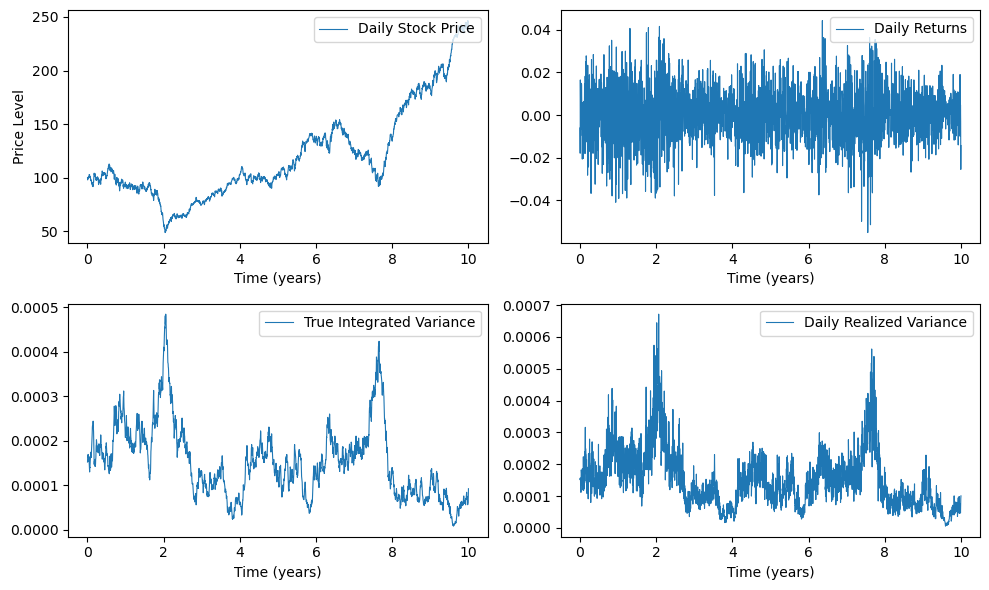

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [68]:
param_bounds = [
    (0.05, 0.5),   # mu
    (1, 3),        # kappa
    (0.05, 0.2),   # theta
    (0.01, 0.8),  # xi
    (-1, 0),       # rho
    V0             # v0
]

In [6]:
burnin = 500
dt = 1  # Daily

split_index = 8 * 252 

# TRAINING SET (first 2016 days)
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET (last 504 days)
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]


# ============================================================================
# 1. BOTH Measurements: Uses both returns and RV
# ============================================================================

# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001])

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

# Get last filtered state from training
train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

# Forecast on test set using final filtered state as initial condition
hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.get_filtered_variance(params=params_opt_both, returns=test_returns, rv=test_RV)

# ============================================================================
# 2. RETURNS Measurement: Uses only returns data
# ============================================================================

hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.get_filtered_variance(params=params_opt_returns, returns=test_returns)

# ============================================================================
# 3. RV Measurement: Uses only realized variance data
# ============================================================================

hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
V_filt_rv_test = hkf_rv_test.get_filtered_variance(params=params_opt_rv, rv=test_RV)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69046D+04    |proj g|=  2.01000D-01

At iterate    1    f= -1.69056D+04    |proj g|=  2.00826D-01

At iterate    2    f= -1.69134D+04    |proj g|=  2.00799D-01

At iterate    3    f= -1.69322D+04    |proj g|=  9.53025D+03

At iterate    4    f= -1.69351D+04    |proj g|=  1.09725D+03

At iterate    5    f= -1.69354D+04    |proj g|=  5.78173D+03

At iterate    6    f= -1.69354D+04    |proj g|=  1.24191D+03

At iterate    7    f= -1.69355D+04    |proj g|=  1.15812D+03

At iterate    8    f= -1.69355D+04    |proj g|=  5.12840D+02

At iterate    9    f= -1.69358D+04    |proj g|=  1.64277D+03

At iterate   10    f= -1.69359D+04    |proj g|=  3.60093D+03

At iterate   11    f= -1.69362D+04    |proj g|=  6.20368D+03

At iterate   12    f= -1.69370D+04    |proj g|=  1.03567D+04

At iterate   13    f= -1.6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   54    f= -4.55297D+03    |proj g|=  1.75767D+03

QMLE Results for Heston Model:
At iterate   55    f= -4.55297D+03    |proj g|=  1.75767D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     55    157     62     1     0   1.758D+03  -4.553D+03
  F =  -4552.9671243331386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

--------------------------------------------------
kappa: 0.007980
theta: 0.000153
xi: 0.004127
mu: 0.000262
Negative Log-Likelihood: -4552.967124
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [0.00798018 0.00015


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    1    f= -1.19269D+04    |proj g|=  4.68318D+02

At iterate    2    f= -1.32325D+04    |proj g|=  3.14207D-03
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    3    f= -1.32918D+04    |proj g|=  2.74079D-03

At iterate    4    f= -1.32918D+04    |proj g|=  2.74835D-03

At iterate    5    f= -1.32926D+04    |proj g|=  3.45160D+02

At iterate    6    f= -1.32938D+04    |proj g|=  1.03547D+03

At iterate    7    f= -1.32978D+04    |proj g|=  7.92358D+03

At iterate    8    f= -1.32984D+04    |proj g|=  5.69744D+02

At iterate    9    f= -1.32986D+04    |proj g|=  6.30506D+02

At iterate   10    f= -1.32986D+04    |proj g|=  3.85527D+02

At iterate   11    f= -1.32986D+04    |proj g|=  4.41405D+02

At iterate   12    f= -1.32987D+04    |proj g|=  1.15520D+03

At iterate   13    f= -1.32992D+04    |proj g|=  2.28160D+02

At iterate   14    f= -1.32994D+04    |proj g|=  1.34441D+03

At iterate   15    f= -1.32996D+04    |proj g|=  1.97026D+0

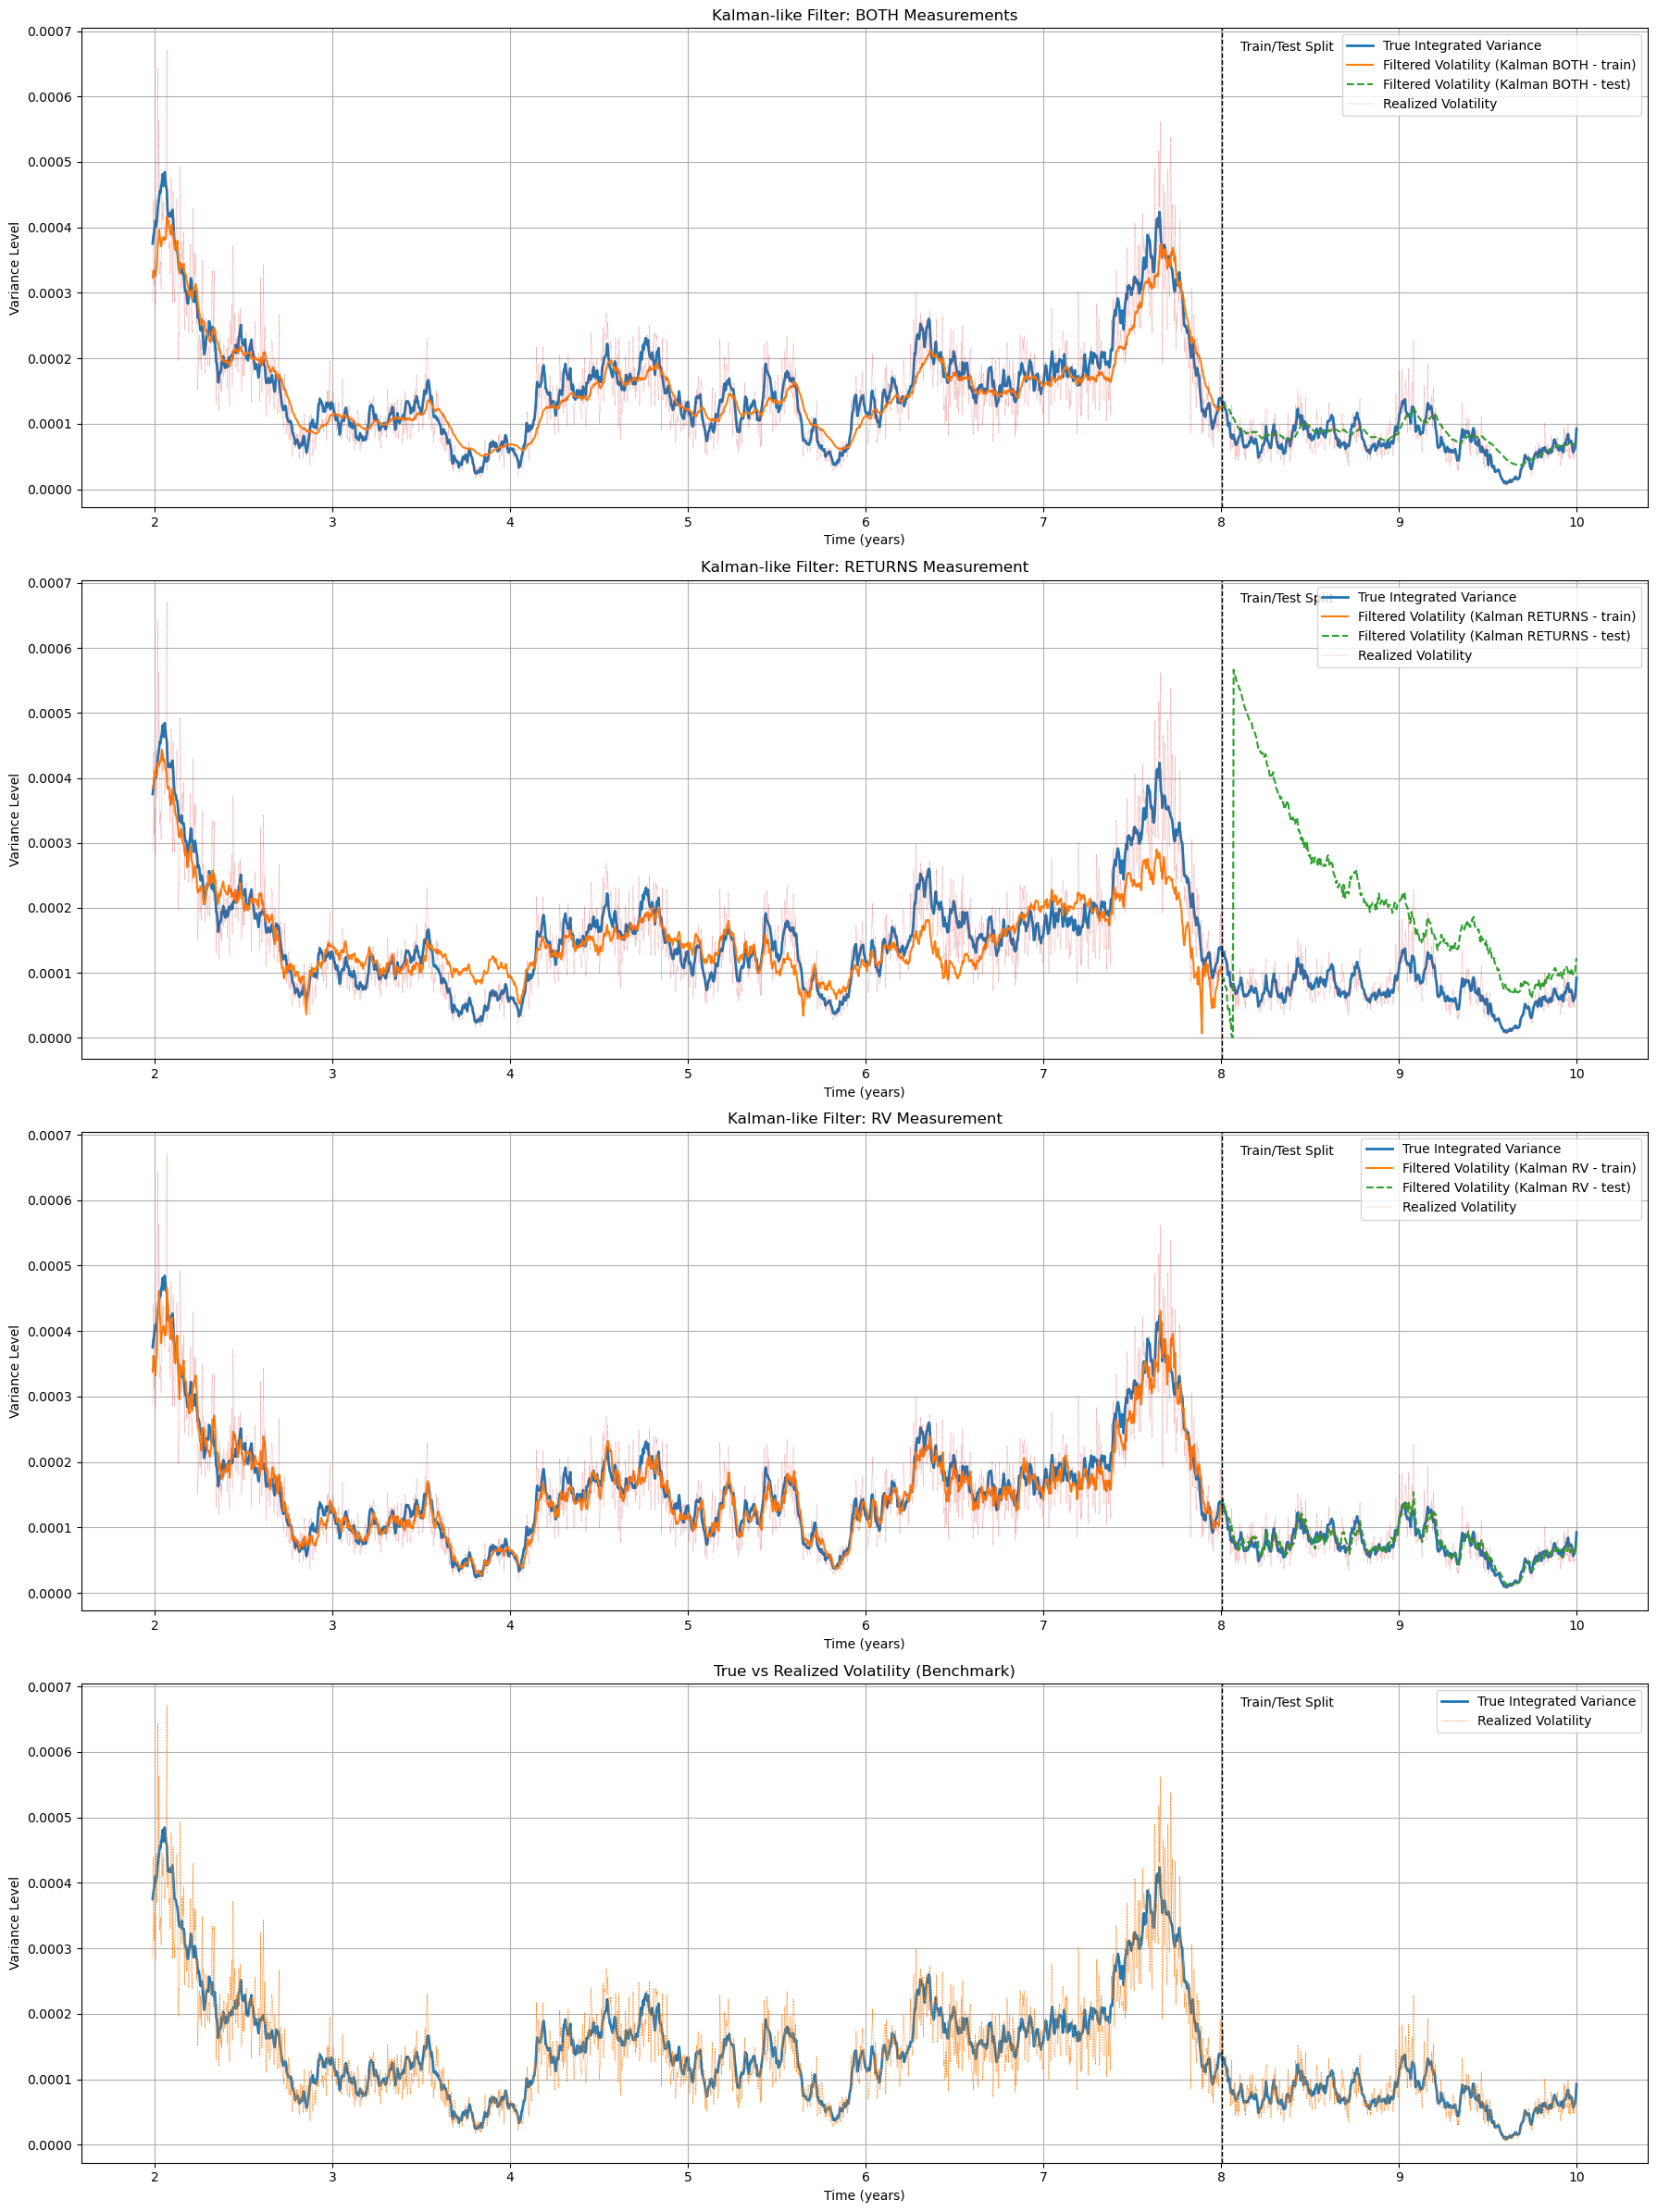

In [8]:
burnin = 500
train_years = 8
test_years = 2
split_day = train_years * 252

# Extract V_filt for training set
V_filt_both = train_result_both['V_filt']
V_filt_returns = train_result_returns['V_filt']
V_filt_rv = train_result_rv['V_filt']

# Create 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(18, 24))
titles = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement"]
filtered_train = [V_filt_both, V_filt_returns, V_filt_rv]
filtered_test = [V_filt_both_test, V_filt_returns_test, V_filt_rv_test]
labels = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV"]

for i in range(3):
    ax = axes[i]

    # Plot true variance
    ax.plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)

    # Plot filtered variance: training
    ax.plot(time_daily[burnin:split_day], filtered_train[i][burnin:], label=f"Filtered Volatility ({labels[i]} - train)", lw=1.5)

    # Plot filtered variance: forecast
    ax.plot(time_daily[split_day:], filtered_test[i], label=f"Filtered Volatility ({labels[i]} - test)", lw=1.5, linestyle='--')

    # Plot realized volatility
    ax.plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle=":")

    # Add vertical line to show split between train/test
    ax.axvline(time_daily[split_day], color='black', linestyle='--', lw=1)
    ax.text(time_daily[split_day] + 0.1, ax.get_ylim()[1]*0.95, 'Train/Test Split', color='black')

    # Title, labels, etc.
    ax.set_title(f"Kalman-like Filter: {titles[i]}")
    ax.set_xlabel("Time (years)")
    ax.set_ylabel("Variance Level")
    ax.legend(loc="upper right")
    ax.grid(True)

# 4th plot: true vs realized only (optional)
axes[3].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[3].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.4, linestyle="--")
axes[3].axvline(time_daily[split_day], color='black', linestyle='--', lw=1)
axes[3].text(time_daily[split_day] + 0.1, axes[3].get_ylim()[1]*0.95, 'Train/Test Split', color='black')
axes[3].set_title("True vs Realized Volatility (Benchmark)")
axes[3].set_xlabel("Time (years)")
axes[3].set_ylabel("Variance Level")
axes[3].legend(loc="upper right")
axes[3].grid(True)

plt.tight_layout()
plt.show()


In [69]:
burnin = 500
dt = 1  # Daily

# ============================================================================
# 1. BOTH Measurements: Uses both returns and RV
# ============================================================================

# Instantiate the Kalman filter for BOTH measurement type.
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=R_daily, rv=daily_RV)
# For BOTH, parameter order is: [kappa, theta, xi, mu, sigma]
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001])
param_bound_both = [
    (1, 3), # kappa
    (1e-6, None),     # theta
    (1e-6, None),     # xi
    (-0.2, 0.2),      # mu
    (0.01, 2.0)       # sigma
]
# Fit the model using the burnin (likelihood uses only t ≥ burnin).
fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)
# Retrieve filtered variance.
V_filt_both = hkf_both.get_filtered_variance()

# ============================================================================
# 2. RETURNS Measurement: Uses only returns data
# ============================================================================

hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=R_daily)
# Parameter order for RETURNS is: [kappa, theta, xi, mu]
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])
param_bound_returns = [
    (1, 3), # kappa
    (1e-6, None),     # theta
    (1e-6, None),     # xi
    (-0.2, 0.2)       # mu
]
fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)
V_filt_returns = hkf_returns.get_filtered_variance()

# ============================================================================
# 3. RV Measurement: Uses only realized variance data
# ============================================================================

hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
# For RV-only, only the RV data is provided.
hkf_rv.set_data(rv=daily_RV)
# Parameter order for RV is: [kappa, theta, xi, sigma]
# initial_params_rv = np.array([0.8, 0.01, 0.001, 0.5])
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])
param_bound_both = [
    (1, 3), # kappa
    (1e-6, None),     # theta
    (1e-6, None),     # xi
    (1e-6, 2.0)       # sigma
]
fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)
V_filt_rv = hkf_rv.get_filtered_variance()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.27186D+04    |proj g|=  2.01000D-01

At iterate    1    f= -2.27195D+04    |proj g|=  2.00872D-01

At iterate    2    f= -2.27467D+04    |proj g|=  2.00824D-01

At iterate    3    f= -2.27570D+04    |proj g|=  2.06499D+04

At iterate    4    f= -2.27576D+04    |proj g|=  2.06917D+03

At iterate    5    f= -2.27576D+04    |proj g|=  2.09788D+03

At iterate    6    f= -2.27581D+04    |proj g|=  1.27178D+03

At iterate    7    f= -2.27582D+04    |proj g|=  9.32234D+02

At iterate    8    f= -2.27583D+04    |proj g|=  9.88253D+02

At iterate    9    f= -2.27585D+04    |proj g|=  1.65112D+03

At iterate   10    f= -2.27588D+04    |proj g|=  7.87007D+03

At iterate   11    f= -2.27601D+04    |proj g|=  7.16959D+02

At iterate   12    f= -2.27607D+04    |proj g|=  1.18808D+04

At iterate   13    f= -2.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



QMLE Results for Heston Model:
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

--------------------------------------------------
kappa: 0.007791
theta: 0.000094
xi: 0.004125
mu: 0.001036
Negative Log-Likelihood: -5479.094083
Convergence: False
Message: ABNORMAL_TERMINATION_IN_LNSRCH
--------------------------------------------------
Optimized parameters (RETURNS): [7.79135111e-03 9.44240312e-05 4.12485061e-03 1.03571210e-03]

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     54    224     61     1     3   2.911D+06  -6.213D+03
  F =  -6212.9052163347933     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate    1    f= -1.74498D+04    |proj g|=  3.08849D+03

At iterate    2    f= -1.75454D+04    |proj g|=  3.50135D+03

At iterate    3    f= -1.77387D+04    |proj g|=  2.64353D+03

At iterate    4    f= -1.77813D+04    |proj g|=  2.56573D-03
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    5    f= -1.79086D+04    |proj g|=  2.40586D-03

At iterate    6    f= -1.79725D+04    |proj g|=  2.56178D-03

At iterate    7    f= -1.79875D+04    |proj g|=  1.99754D+00

At iterate    8    f= -1.79926D+04    |proj g|=  1.40544D+04

At iterate    9    f= -1.79948D+04    |proj g|=  1.04710D+04

At iterate   10    f= -1.79982D+04    |proj g|=  5.01075D+03

At iterate   11    f= -1.79988D+04    |proj g|=  1.49396D+03

At iterate   12    f= -1.79991D+04    |proj g|=  1.20853D+03

At iterate   13    f= -1.79991D+04    |proj g|=  3.57222D+02

At iterate   14    f= -1.79991D+04    |proj g|=  3.90926D+02

At iterate   15    f= -1.79991D+04    |proj g|=  3.87527D+0

In [70]:
pf_heston = pf.PFHeston(np.log(S_daily), N=5000, is_log=True)

param_bounds = [
    (0.05, 0.5),   # mu
    (1, 3),        # kappa
    (0.05, 0.2),   # theta
    (0.01, 0.8),  # xi
    (-1, 0),       # rho
    V0            # v0
]

V_pf, param_steps = pf_heston.filter(param_bounds, predict_obs=False)
V_pf = V_pf / 252

resampling since: 1511.233396988465
resampling since: 2374.7145590976497
resampling since: 1687.7351095474526
resampling since: 829.1718213373316
resampling since: 3062.397356905797
resampling since: 2575.114956648601
resampling since: 468.34845809644617
resampling since: 94.45828266136635
resampling since: 931.3918359856331
resampling since: 1943.6094009056455
resampling since: 2966.678539228874
resampling since: 1748.4672666923213
resampling since: 176.47500026491082
resampling since: 3323.340522015717
resampling since: 3322.767969686327
resampling since: 1186.367428622764
resampling since: 1838.4882210201847
resampling since: 3357.7381090916188
resampling since: 3331.167581794232
resampling since: 1596.492983887279
resampling since: 30.46239750368404
resampling since: 627.8575501120978
resampling since: 3314.7554836112
resampling since: 2503.9033057506417
resampling since: 3169.1443971139042
resampling since: 1249.84692882191
resampling since: 1917.6933968227781
resampling since: 24

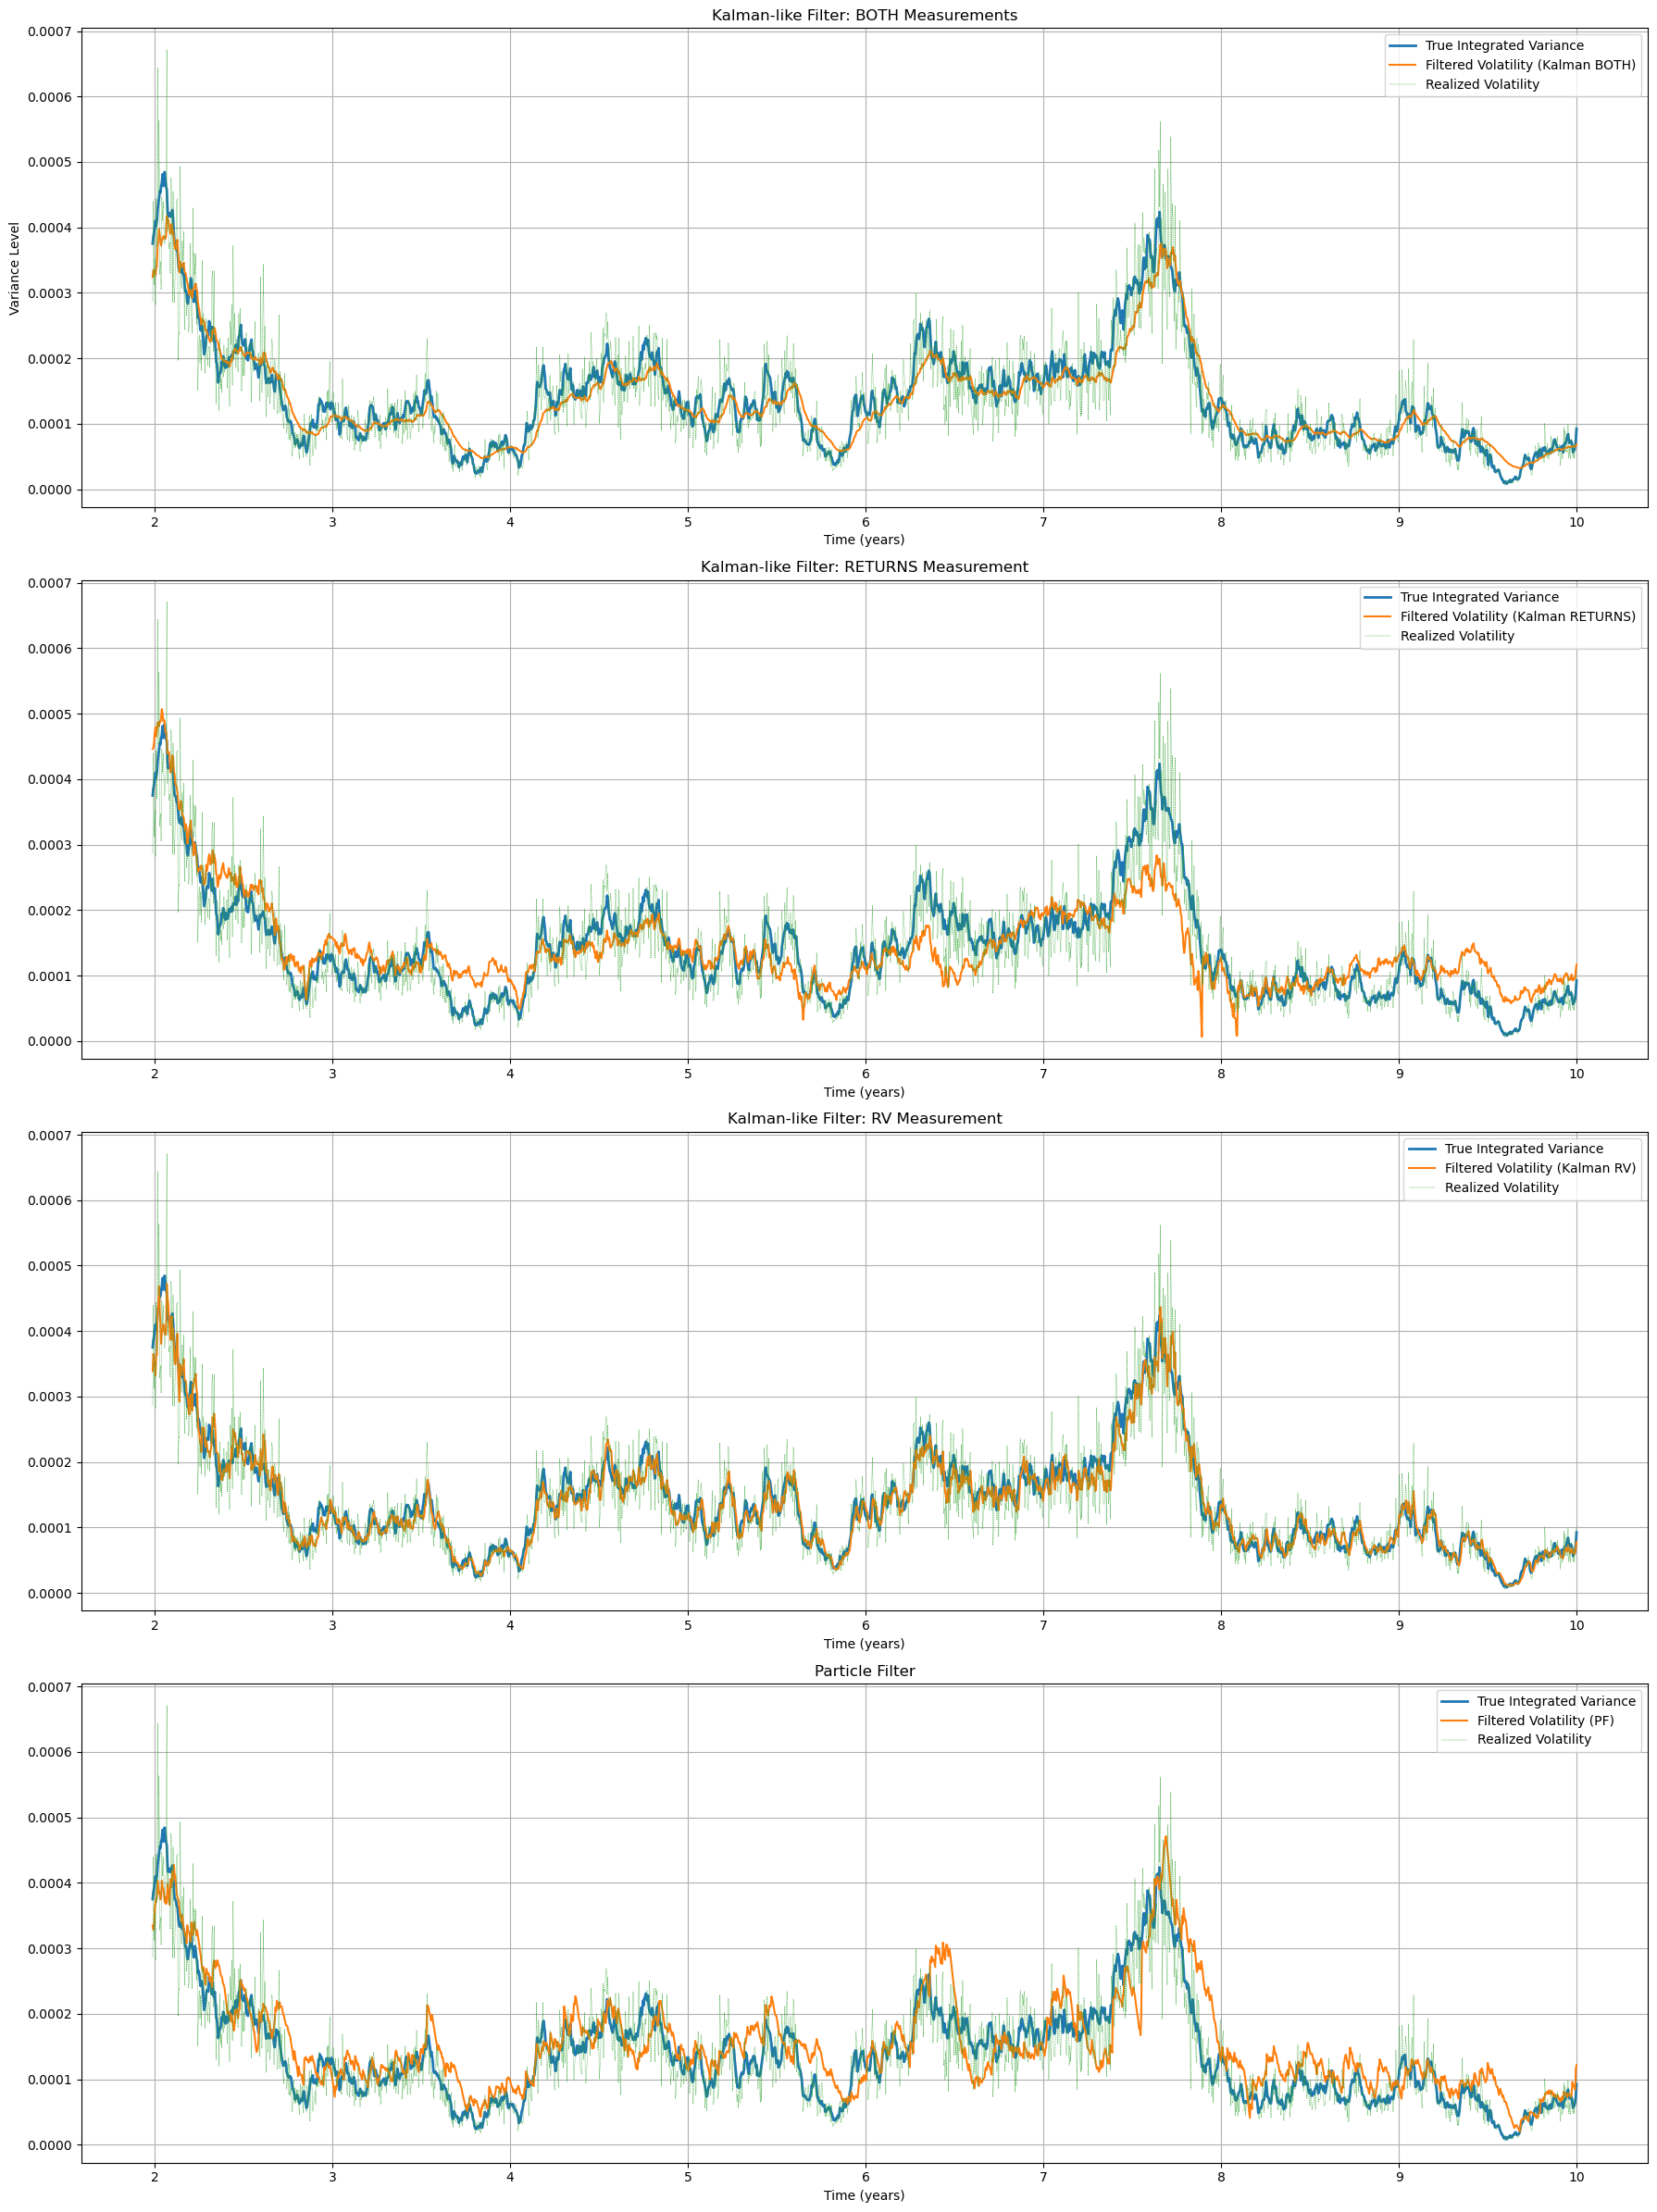

RMSE (PF - Filtered vs True): 0.000043
RMSE (RETURNS - Filtered vs True): 0.000041
RMSE (BOTH - Filtered vs True): 0.000025
RMSE (RV - Filtered vs True): 0.000017

--- Model Summary: BOTH ---

Heston Kalman Filter Summary
Measurement Type: both
Time Interval (dt): 1
Initial Variance (V0): 0.010000
Initial Covariance (P0): 0.100000

Fitted Parameters:
--------------------------------------------------
kappa: 0.005585
theta: 0.000103
xi: 0.000641
mu: 0.000654
sigma: 0.000026

Negative Log-Likelihood: -22761.345969
Convergence: True

AIC: -45512.691938
BIC: -45483.533851

--- Model Summary: RETURNS ---

Heston Kalman Filter Summary
Measurement Type: returns
Time Interval (dt): 1
Initial Variance (V0): 0.010000
Initial Covariance (P0): 0.100000

Fitted Parameters:
--------------------------------------------------
kappa: 0.007791
theta: 0.000094
xi: 0.004125
mu: 0.001036

Negative Log-Likelihood: -5479.094083
Convergence: False
Message: ABNORMAL_TERMINATION_IN_LNSRCH

AIC: -10950.188165
BI

In [71]:
burnin = 500

# Create 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(18, 24))

# 1: BOTH measurements
axes[0].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[0].plot(time_daily[burnin:], V_filt_both[burnin:], label="Filtered Volatility (Kalman BOTH)", lw=1.5)
# axes[0].plot(time_daily[burnin:], hkf_both.get_predicted_variance()[burnin:], label="Filtered Volatility (Kalman BOTH)", lw=1.5)

axes[0].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[0].set_title("Kalman-like Filter: BOTH Measurements")
axes[0].set_xlabel("Time (years)")
axes[0].set_ylabel("Variance Level")
axes[0].legend(loc="upper right")
axes[0].grid(True)

# 2: RETURNS measurement
axes[1].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[1].plot(time_daily[burnin:], V_filt_returns[burnin:], label="Filtered Volatility (Kalman RETURNS)", lw=1.5)
# axes[1].plot(time_daily[burnin:], hkf_returns.get_predicted_variance()[burnin:], label="Filtered Volatility (Kalman RETURNS)", lw=1.5)

axes[1].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[1].set_title("Kalman-like Filter: RETURNS Measurement")
axes[1].set_xlabel("Time (years)")
axes[1].legend(loc="upper right")
axes[1].grid(True)

# 3: RV measurement
axes[2].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[2].plot(time_daily[burnin:], V_filt_rv[burnin:], label="Filtered Volatility (Kalman RV)", lw=1.5)
# axes[2].plot(time_daily[burnin:], hkf_rv.get_predicted_variance()[burnin:], label="Filtered Volatility (Kalman RV)", lw=1.5)

axes[2].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[2].set_title("Kalman-like Filter: RV Measurement")
axes[2].set_xlabel("Time (years)")
axes[2].legend(loc="upper right")
axes[2].grid(True)

# 4: Particle Filter
axes[3].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[3].plot(time_daily[burnin:], V_pf[burnin:], label="Filtered Volatility (PF)", lw=1.5)
axes[3].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[3].set_title("Particle Filter")
axes[3].set_xlabel("Time (years)")
axes[3].legend(loc="upper right")
axes[3].grid(True)

plt.tight_layout()
plt.show()

# Compute RMSE (Post Burnin)
true_post = daily_true_V[burnin:]
rmse_both = np.sqrt(np.mean((true_post - V_filt_both[burnin:]) ** 2))
rmse_returns = np.sqrt(np.mean((true_post - V_filt_returns[burnin:]) ** 2))
rmse_rv = np.sqrt(np.mean((true_post - V_filt_rv[burnin:]) ** 2))
rmse_pf = np.sqrt(np.mean((true_post - V_pf[burnin:]) ** 2))

print(f"RMSE (PF - Filtered vs True): {rmse_pf:.6f}")
print(f"RMSE (RETURNS - Filtered vs True): {rmse_returns:.6f}")
print(f"RMSE (BOTH - Filtered vs True): {rmse_both:.6f}")
print(f"RMSE (RV - Filtered vs True): {rmse_rv:.6f}")

# Print Model Summaries for Each Measurement Type
print("\n--- Model Summary: BOTH ---")
hkf_both.summary()

print("\n--- Model Summary: RETURNS ---")
hkf_returns.summary()

print("\n--- Model Summary: RV ---")
hkf_rv.summary()


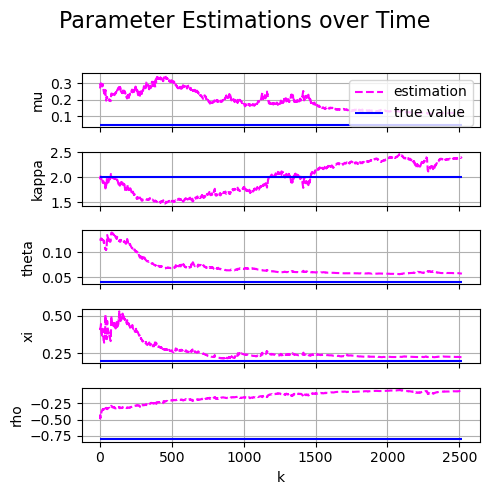

In [38]:
param_names = ['mu', 'kappa', 'theta', 'xi', 'rho']

fig, axs = plt.subplots(5, 1, figsize=(5, 5), sharex=True)
fig.suptitle('Parameter Estimations over Time', fontsize=16)

# Plot each parameter
for i in range(5):
    axs[i].plot(param_steps[i], linestyle='--', color='magenta', label='estimation')
    axs[i].hlines(params[param_names[i]], 0, param_steps.shape[1]-1, colors='blue', label='true value')
    axs[i].set_ylabel(param_names[i])
    axs[i].grid(True)

# Set common x-axis label
axs[-1].set_xlabel('k')

# Only add one legend (avoid repeated)
axs[0].legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

In [13]:
np.zeros((1,2))

array([[0., 0.]])